In [1]:
#!pip install transformers

In [2]:
import pandas as pd
pd.options.display.max_colwidth = None
import numpy as np
from transformers import BertTokenizer, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

from sklearn.model_selection import train_test_split

/Users/urvog/miniconda3/envs/envNLPTensorFlow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metal device set to: Apple M1 Pro


2022-07-09 23:47:57.656084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-09 23:47:57.656180: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
#modelo a utilizar
nombre_modelo = 'bert-base-multilingual-uncased'

In [4]:
path_datasets = !ls data/

In [5]:
path_datasets

['df_anger.csv',
 'df_anticipation.csv',
 'df_disgust.csv',
 'df_fear.csv',
 'df_joy.csv',
 'df_love.csv',
 'df_optimism.csv',
 'df_pessimism.csv',
 'df_sadness.csv',
 'df_surprise.csv',
 'df_trust.csv',
 'sem_eval_test_blank_es.csv',
 'sem_eval_train_es.csv']

In [11]:
# Leemos los datos
df = pd.read_csv('data/df_anger.csv')

df.head()

,Tweet,anger
0,"@aliciaenp Ajajjaa somos del clan twitteras perdidas pa eventos ""importantes""",0
1,@AwadaNai la mala suerte del gato fichame la cara de help me pls,0
2,@audiomano A mí tampoco me agrado mucho eso. Especialmente por tratarse de él. No hay justificación.,1
3,"Para llevar a los bebes de un lugar a otro debemos cantarles canciones... Quiero cantarles Gunaa' nibiina (La llorona, en Zapoteco)",0
4,"@DalasReview me encanta la terrible hipocresia y doble moral que tiene esta gente, claro, cuando ella te lo quita ILEGALMENTE no importa...",1


## Limpieza de datos

In [12]:
import re, string

pattern1 = re.compile(r'@[\w_]+') #elimina menciones
pattern2 = re.compile(r'https?://[\w_./]+') #elimina URL
pattern3 = re.compile(r'#[\w_]+') #elimina hashtags
pattern4 = re.compile('[{}]+'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text):
    """Limpiamos las menciones, URL y hashtags del texto. Luego 
    quitamos signos de puntuación"""
    text = pattern1.sub('mención', text)
    text = pattern2.sub('URL', text)
    text = pattern3.sub('hashtag', text)
    text = pattern4.sub(' ', text)
    
    return text

## Preparamos los datos

In [13]:
#limpiamos texto y quitamos tweets que se han quedado vacíos
df.Tweet=df.Tweet.apply(clean_text)
df = df[df['Tweet']!='']
#el conjunto de salida es la polaridad, hay que convertir a binario
#codificamos 'P' como 1 y 'N' se queda como 0
Y=df.anger

#Separamos entrenamiento y test
#realmente habría que sacar los tokens sólo del conjunto de entrenamiento...
X_train_tweets, X_test_tweets, Y_train, Y_test = train_test_split(df.Tweet,Y, test_size = 0.3, random_state = 42)
print(X_train_tweets.shape,Y_train.shape)
print(X_test_tweets.shape,Y_test.shape)

(2492,) (2492,)
(1069,) (1069,)


## Preparamos los datos para entrada al modelo

In [14]:
#Tokenizamos y codificamos como Dataset
tokenizer = BertTokenizer.from_pretrained(nombre_modelo)
train_encodings = tokenizer(X_train_tweets.to_list(), truncation=True, padding=True, return_tensors="tf")

In [15]:
MAX_SEQUENCE_LENGTH=train_encodings['input_ids'].shape[1]
test_encodings = tokenizer(X_test_tweets.to_list(), truncation=True, padding='max_length', max_length=MAX_SEQUENCE_LENGTH, return_tensors="tf")

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    Y_train
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    Y_test
))

## Fine Tunning con BERT

In [19]:
#definimos modelo de clasificación
config = BertConfig.from_pretrained(nombre_modelo, hidden_dropout_prob=0.1, num_labels=2)
model = TFBertForSequenceClassification.from_pretrained(nombre_modelo, config=config)
model.bert.trainable = False #congelamos la actualización de las capas del BERT
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  167356416 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 167,357,954
Trainable params: 1,538
Non-trainable params: 167,356,416
_________________________________________________________________


In [ ]:
batch_size=8
history=model.fit(train_dataset.batch(batch_size), epochs=10, batch_size=batch_size, validation_data=test_dataset.batch(batch_size))

Epoch 1/10


2022-07-09 23:52:04.051496: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-09 23:52:04.052421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - ETA: 0s - loss: 0.6572 - accuracy: 0.6409

2022-07-09 23:52:41.804461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


312/312 [==============================] - 60s 167ms/step - loss: 0.6572 - accuracy: 0.6409 - val_loss: 0.6326 - val_accuracy: 0.6735
Epoch 2/10
312/312 [==============================] - 48s 154ms/step - loss: 0.6315 - accuracy: 0.6750 - val_loss: 0.6295 - val_accuracy: 0.6735
Epoch 3/10
312/312 [==============================] - 48s 154ms/step - loss: 0.6300 - accuracy: 0.6750 - val_loss: 0.6292 - val_accuracy: 0.6735
Epoch 4/10
312/312 [==============================] - 49s 157ms/step - loss: 0.6295 - accuracy: 0.6754 - val_loss: 0.6292 - val_accuracy: 0.6745
Epoch 5/10
312/312 [==============================] - 49s 156ms/step - loss: 0.6290 - accuracy: 0.6758 - val_loss: 0.6291 - val_accuracy: 0.6745
Epoch 6/10
312/312 [==============================] - 49s 157ms/step - loss: 0.6287 - accuracy: 0.6758 - val_loss: 0.6291 - val_accuracy: 0.6745
Epoch 7/10
312/312 [==============================] - 49s 158ms/step - loss: 0.6283 - accuracy: 0.6762 - val_loss: 0.6290 - val_accuracy: 0.6

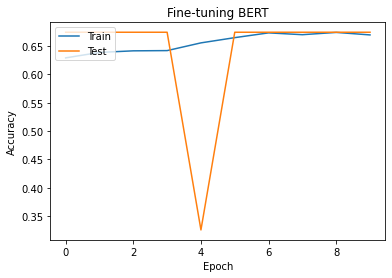

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Fine-tuning BERT')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()